In [28]:
import math
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import GroverOperator,MCMT,ZGate


In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService(channel='ibm_quantum', token='a2f9744693bb7fbb26e5423c01361ee3e9770050c3c130192d3111ba2836af6e8a683a9d9ba7f5010d0c933bacc86b04e79f822fe5060d66f348079fa8dbac57')
backend = service.least_busy(operational=True, simulator= False)
backend.name

'ibm_kyoto'

In [30]:
def grover_oracle(marked_states) -> QuantumCircuit:

    """build a grover oracle for multiple marked states ,
      we assume all  input marked sates have the same number of bits,
      we are passing marked_states as parameters which is a list, 
      our functions then returns quantum circuit representing grover_oracle"""
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
        
    num_qubits = len(marked_states[0])   # number of qubits in the oracle/circuit)
         #by getting the length of the first marked state assuming all marked states have same length

    circuit = QuantumCircuit(num_qubits) 
    for target in marked_states: # for each marked state in the input list states
        rev_target = target[::-1]  # flip target bit-string to match qiskit's qubit-ordering,the qubit with the lowest index is the least significant bit, so we reverse the bit string to align with this convention in qiskit
        zero_ind = [ind for ind in range(num_qubits) if rev_target.startswith('0', ind)] # --> constructed to identify the positions where the qubits should be flipped to '|0> to construct the grover oracle
            
        for ind in zero_ind:
                circuit.x(zero_ind) # apply x-gate to the qubits(zero indices) that are in the |0> state

        circuit.h(num_qubits - 1) # apply hadamard gate to the last qubit
        circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1) # apply multi-controlled X-gate
        circuit.h(num_qubits - 1) # apply hadamard gate to the last qubit

        for ind in zero_ind:
            circuit.x(zero_ind)  # --> apply x-gates again to revert the state
        circuit.compose(MCMT(ZGate(), num_qubits - 1,1), inplace=True) # apply multi-controlled Z-gate to the last qubit

        circuit.barrier() # barrier to separate the oracle from the diffuser,, ensuring clarity of the circuit

    return circuit

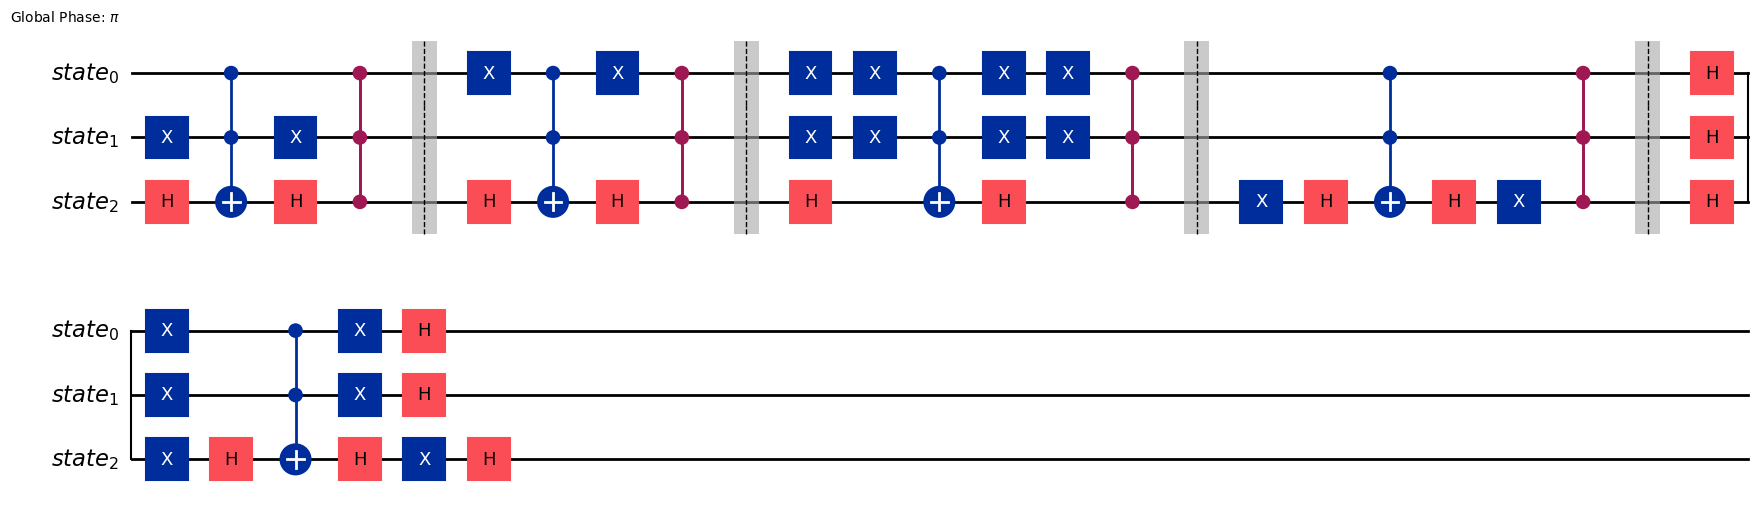

In [31]:
# --> Now that we have our function to build the grover oracle , we can define the grover search function

marked_states = ['101', '110','100','011'] # list of marked states
oracle = grover_oracle(marked_states) # build the grover oracle

grover_operator = GroverOperator(oracle)
grover_operator.decompose().draw(output='mpl', style='iqp')

In [32]:
optimal_num_iterations = math.floor(math.pi / (4 *math.asin(math.sqrt(len(marked_states) / 2**grover_operator.num_qubits))))
print(f"Optimal number of iterations: {optimal_num_iterations}")
# --> Now that we have the optimal number of iterations, we can build the Grover search circuit ,required for circuit amplification of the marked_states

Optimal number of iterations: 0


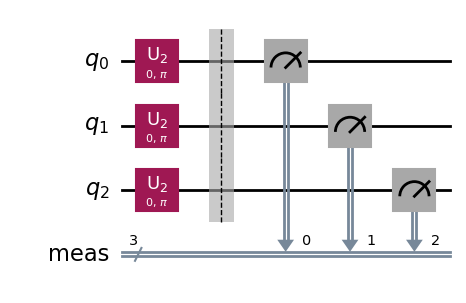

In [33]:
# --> full grover experiment begins with H on each qubit; creating a superposition of all computational basis states
# --> followed by the optimal number of iterations of the Grover operator

circuit = QuantumCircuit(grover_operator.num_qubits)
circuit.h(range(grover_operator.num_qubits))
circuit.compose(grover_operator.power(optimal_num_iterations), inplace=True)

circuit.measure_all()

circuit.decompose().draw(output='mpl', style='iqp')

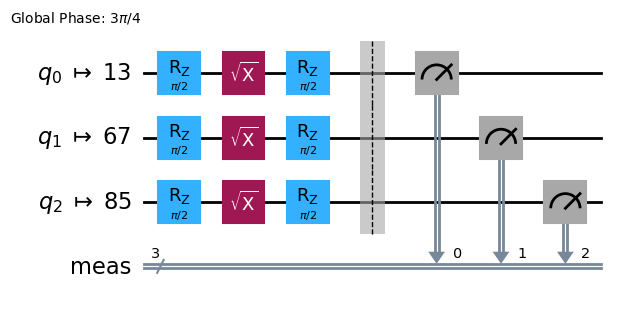

In [34]:
# --> Optimizing the circuit using the Qiskit transpiler for quantum execution

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pass_manager = generate_preset_pass_manager(target=target, optimization_level=3)
optimized_circuit = pass_manager.run(circuit)

optimized_circuit.draw(output='mpl', idle_wires=False, style='iqp')

In [36]:
# --> amplitude amplification is suitable for execution with the Sampler runtime

sampler = Sampler(backend=backend)
sampler.options.default_shots = 5000
job = sampler.run([optimized_circuit]).result()


# --> retrieve the result of the job
dist = job[0].data.meas.get_counts()

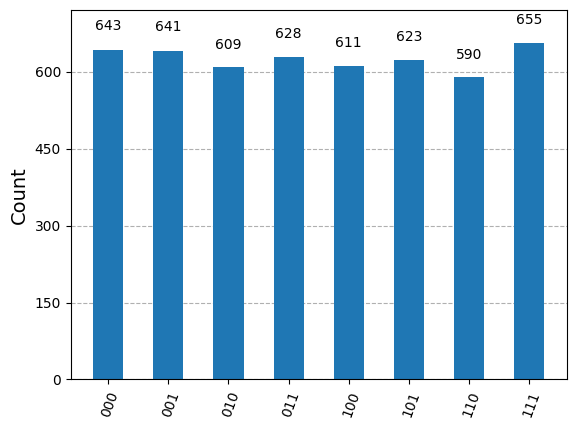

In [37]:
from qiskit.visualization import plot_histogram
plot_histogram(dist)